In [9]:
import numpy as np
from matplotlib import pyplot as plt
from mne import time_frequency, create_info, EpochsArray
import seaborn as sns
# fooof
from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum

In [12]:
import sys
sys.path.insert(0, 'C:/Users/camil/Documents/int/inVibe/')
from trials import select_trials

In [4]:
py_filepath = "C:/Users/camil/Documents/int/data/openephys/test_results/LIP/2022-11-22_10-59-03_Riesling_lip_e1_r1.npy"

py_f = np.load(py_filepath, allow_pickle=True).item(0)
sp_py = py_f["sp_data"]
bhv_py = py_f["bhv"]
print('sp_py keys:')
print(sp_py.keys())
print('bhv_py trial keys:')
print(bhv_py[0].keys())

sp_py keys:
dict_keys(['sp_samples', 'blocks', 'code_numbers', 'code_samples', 'eyes_values', 'lfp_values', 'samples', 'clusters_id', 'clusters_ch', 'clustersgroup', 'clusterdepth'])
bhv_py trial keys:
dict_keys(['trial', 'AbsoluteTrialStartTime', 'Btn1', 'Btn10', 'Btn2', 'Btn3', 'Btn4', 'Btn5', 'Btn6', 'Btn7', 'Btn8', 'Btn9', 'Eye', 'Eye2', 'EyeExtra', 'Gen1', 'Gen10', 'Gen11', 'Gen12', 'Gen13', 'Gen14', 'Gen15', 'Gen16', 'Gen2', 'Gen3', 'Gen4', 'Gen5', 'Gen6', 'Gen7', 'Gen8', 'Gen9', 'Joystick', 'Joystick2', 'KeyInput', 'Mouse', 'PhotoDiode', 'SampleInterval', 'Touch', 'CodeNumbers', 'CodeTimes', 'Block', 'BlockCount', 'Condition', 'CycleRate', 'Angle', 'BackgroundColor', 'Info', 'Position1', 'Position2', 'Position3', 'Position4', 'Position5', 'Position6', 'Scale', 'Status', 'Time', 'Zorder', 'ReactionTime', 'EndTimes', 'StartTimes', 'Attribute11', 'Attribute12', 'Attribute13', 'Attribute21', 'Attribute22', 'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26', 'Code', 'FrameByF

#### Aligne lfps with an event and cut

In [29]:
n_block = 2
trials_idx = select_trials.select_trials_block(sp_py,n_block)
trials_idx = select_trials.select_correct_trials(bhv_py,trials_idx)

Number of trials in block 2: 104
Number of correct trials in block 2: 80


In [20]:
lfp=sp_py['lfp_values']
samples= sp_py['samples']

In [17]:
lfp[0].shape

(32, 4029)

In [35]:
target_on = 37
event = target_on
t_before = -0.7
t_after = 2
fs = 30000

In [27]:
(t_after-t_before)*fs

81000.0

In [59]:
n_samples = int((t_after-t_before)*fs)
lfp_aligned = []#np.zeros((len(lfp), lfp[0].shape[0], n_samples))
samples_aligned = []#np.zeros((len(lfp),n_samples))
for n_trial in trials_idx:
    idx_event = np.where(sp_py["code_numbers"][n_trial] == event)[0]# index when the event occurs
    sample_event = sp_py["code_samples"][n_trial][idx_event] # sample when the event occurs
    # Shift samples to align with event
    samples_shift = samples[n_trial] - sample_event
    # cut samples and lfps
    idx_cut = np.where(np.logical_and(samples_shift>= t_before * fs,samples_shift<=t_after*fs))[0]
    # append results
    samples_aligned.append(samples_shift[idx_cut])
    lfp_aligned.append(lfp[n_trial][:,idx_cut])

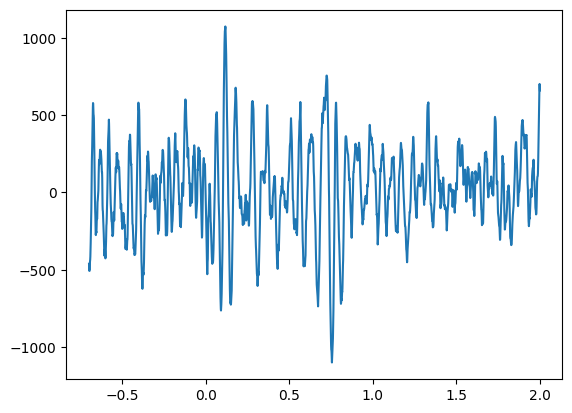

In [61]:
plt.plot(samples_aligned[-1]/fs,lfp_aligned[-1][0])

In [ ]:

# create list of neurons containing trials belonging to one target location
target_trials = trials_idx[code]["trials_idx"]  # select trials idx
code_trials = sp_py["sp_samples"][target_trials]  # select trials
neuron_trials = []
for i_t, n_trial in zip(target_trials, code_trials):
    idx_target_on = np.where(sp_py["code_numbers"][i_t] == target_on)[0]
    sample_target_on = sp_py["code_samples"][i_t][idx_target_on]
    neuron_trials.append(n_trial[neuron] - sample_target_on)


In [5]:
channels

array([ 450., 1250., 1250., 1500., 1300.,  150.,  700., 1400.,  850.,
       1000.,  850., 1000., 1600.,  700.,  600., 1300.])

In [ ]:
channels = np.load(channels_path)
lfp = np.load(lfps_path) # shape = trials x ch x time

In [ ]:
print("Number of channels: %d"%(channels.shape[0]))
print("Trials: %d, channels: %d, timestamps: %d"%(lfp.shape[0],lfp.shape[1],lfp.shape[2]))

In [ ]:
ch_name = 'PMd'
# Select the channels that contain ch_name in their name
channel_mask_PMd = np.array([False if channel.find(ch_name) == -1 else True for channel in channels])

In [ ]:
print("Number of %s channels: %d"%(ch_name,channels[channel_mask_PMd].shape[0]))

In [ ]:
# ignore if you don't want to zero pad
# zero padding each trial
n_zeros = 200
lfps_pad = np.pad(lfp, ((0, 0),(0, 0),(n_zeros, n_zeros)), 'constant', constant_values=(0, 0))
lfps=lfps_pad
print("Shape lfps: (%s,%s,%s)"%lfps.shape)

In [ ]:
# Compute the psd using welch
s_freq = 1000 # Hz
w_size = 150
psd_welch_1, freqs_welch_1 = time_frequency.psd_array_welch(lfps,fmax=80,sfreq=s_freq,n_per_seg=w_size)
print("Spectrum shape: (%s,%s,%s)"%psd_welch_1.shape)
print("Number of freqs: %d"%freqs_welch_1.shape[0])

In [ ]:
# print the mean power spectrum for each channel (mean across trials)
_,ax = plt.subplots(figsize=(7,5))
for i in range(psd_welch_1.mean(axis=(0)).shape[0]):
    plt.semilogy(freqs_welch_1,psd_welch_1.mean(axis=(0))[i])
plt.show()

In [ ]:
plt.close('all')

In [ ]:
# Initialize FOOOF object
fm = FOOOF()
# Define frequency range across which to model the spectrum
freq_range = [0, 80]

In [ ]:
# Report: fit the model, print the resulting parameters, and plot the reconstruction
channel=35
fm.report(freqs_welch_1, psd_welch_1.mean(axis=(0))[channel])

In [ ]:
# Combine peak representations
fm.plot(plot_aperiodic=True, plot_peaks='line-shade-outline', plt_log=False)

In [ ]:
# fit fooof for all channels and trials
def get_foof_param(channels_idx,psd_welch_1,freqs_welch_1):
    ch_param = []

    for ch in channels_idx:
        for trial in range(psd_welch_1.shape[0]):
            p=fm.fit(freqs_welch_1, psd_welch_1[trial,ch])
            ch_param.append(fm.peak_params_[:,0])
    return ch_param

In [ ]:
channels_idx=np.where(channel_mask_PMd == True)[0]
param_PMd = get_foof_param(channels_idx,psd_welch_1,freqs_welch_1)

In [ ]:
all_param_list = np.concatenate(param_PMd[:6])
sns.kdeplot(all_param_list)
all_param_list = np.concatenate(param_PMd[6:11])
sns.kdeplot(all_param_list)
all_param_list = np.concatenate(param_PMd[11:16])
sns.kdeplot(all_param_list)
all_param_list = np.concatenate(param_PMd[16:20])
sns.kdeplot(all_param_list)

In [ ]:
sns.boxplot(data=[np.concatenate(param_PMd[:6]),np.concatenate(param_PMd[6:11]),np.concatenate(param_PMd[11:16]),np.concatenate(param_PMd[16:20])])
ax = sns.stripplot(data=[np.concatenate(param_PMd[:6]),np.concatenate(param_PMd[6:11]),np.concatenate(param_PMd[11:16]),np.concatenate(param_PMd[16:20])], color="orange", jitter=0.2, size=2.5)

plt.show()